In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tqdm.notebook import tqdm

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, MSE
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets.mnist import load_data

In [3]:
(x_train, y_train), (x_test, y_test)  = load_data()

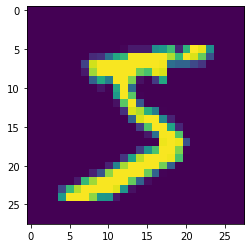

In [3]:
plt.imshow(x_train[0])

In [4]:
width = 128

(4, 96)


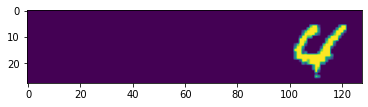

In [5]:
def create_img(x_array, y_array, width):
    height = x_array.shape[1]
    old_width = x_array.shape[2]
    new_img = np.zeros([height, width])
    shift = random.randint(0, width-old_width)
    idx = random.randint(0, x_array.shape[0]-1)
    y = y_array[idx]   
    new_img[:, shift: shift + old_width] = x_array[idx]
    return new_img, (y, shift)

_=create_img(x_train, y_train, width)
plt.imshow(_[0])
print(_[1])

In [6]:
def make_data(x_array, y_array, scope, width):
    imgs = []
    nums = []
    shifts = []
    height = x_array.shape[1]
    for _ in range(scope):
        img, (num, shift) = create_img(x_array, y_array, width)
        imgs.append(img.reshape(height, width, 1))
        nums.append(num)
        shifts.append(shift)
    imgs = np.array(imgs).astype('float32')
    shifts = np.array(shifts).reshape(-1,1)
    nums = np.array(nums).reshape(-1,1)
    imgs = imgs/255
    return imgs, nums, shifts

In [7]:
imgs, nums, shifts = make_data(x_train, y_train, 10000, width)


In [8]:
display(imgs.shape)
display(nums.shape)
display(shifts.shape)

(10000, 28, 128, 1)

(10000, 1)

(10000, 1)

'lable: 4'

'shift: 33'

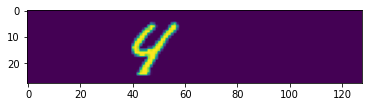

In [9]:
def show_sample(i):
    plt.imshow(imgs[i])
    display(f'lable: {nums[i][0]}')
    display(f'shift: {shifts[i][0]}')
    
show_sample(1000)

In [24]:
np.unique(nums).shape[0]

10

In [55]:
#lineary model api
input_shape = imgs.shape[1:]
filters = 2
kernel_size = 3
padding = 'same'
labels = np.unique(nums)



inp = Input(shape=input_shape)

x = Conv2D(filters=filters**3, 
             kernel_size=kernel_size,
             padding=padding,
             activation='relu')(inp)
x = MaxPool2D()(x)


x = Conv2D(filters=filters ** 5, 
             kernel_size=kernel_size,
             padding=padding,
             activation='relu')(x)
x = MaxPool2D()(x)



x = Conv2D(filters=filters ** 6, 
             kernel_size=kernel_size,
             padding=padding,
             activation='relu')(x)
x = MaxPool2D()(x)


x = Flatten()(x)

output_lin = Dense(1, activation='linear')(x)

lin_model = Model(inputs=inp, outputs=output_lin)






In [ ]:
optim = Adam(learning_rate=.005)
lin_model.compile(loss='mse',
                 optimizer=optim,
                 metrics=['mse'])
lin_model.summary()

In [46]:
input_shape = imgs.shape[1:]
filters = 2
kernel_size = 3
padding = 'same'
labels = np.unique(nums)

inp = Input(shape=input_shape)
x = inp
layers = 5
filters = 2
for i in range(1,layers):
    x = Conv2D(filters=filters**(i+3), 
             kernel_size=kernel_size,
             padding=padding,
             activation='relu')(x)
    x = MaxPool2D()(x)
    
    
x = Flatten()(x)

# l2 = 3
# nodes = 256

# for i in range(l2):
#     x = Dense(nodes, activation='relu')(x)
#     x = Dropout(rate=.3)(x)
#     nodes /= 2
    
output_lin = Dense(1, activation='linear')(x)

lin_auto_model = Model(inputs=inp, outputs=output_lin)

In [47]:
optim = Adam(learning_rate=.005)
lin_auto_model.compile(loss='mse',
                 optimizer=optim,
                 metrics=['mae'])
lin_auto_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 128, 1)]      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 128, 16)       160       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 64, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 7, 32, 32)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 32, 64)         18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 3, 16, 64)         0  

In [48]:
lin_auto_model.fit(x=imgs, y=shifts, epochs=2, batch_size=32)

Train on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 131s 13ms/sample - loss: 77.5246 - mean_absolute_error: 4.3898
Epoch 2/2
10000/10000 [==============================] - 136s 14ms/sample - loss: 5.4024 - mean_absolute_error: 1.7217


In [51]:
shifts.shape

(10000, 1)

In [63]:
# create cls model using api
#hyperparameters
input_shape = imgs.shape[1:]
filters = 8
kernel_size = 3
padding = 'same'
labels = np.unique(nums)


inp = Input(shape=input_shape, name='cls_input')
x = inp
layers = 4
for _ in range(layers):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
              padding='same',
              activation='relu')(x)
    x = MaxPool2D()(x)
    filters *= 2

x = Flatten()(x)
cls_output = Dense(labels.shape[0], activation='softmax')(x)
cls_model = Model(inputs=inp, outputs=cls_output)

In [66]:
optim = Adam(learning_rate=.005)
cls_model.compile(loss='categorical_crossentropy',
                 optimizer=optim,
                  metrics=['accuracy'])
cls_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cls_input (InputLayer)       [(None, 28, 128, 1)]      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 28, 128, 8)        80        
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 14, 64, 8)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 14, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 7, 32, 16)         0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 7, 32, 32)         4640      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 3, 16, 32)         0  

In [74]:
nums_cat = to_categorical(nums)

In [75]:
nums_cat.shape

(10000, 10)

In [76]:
cls_model.fit(imgs, nums_cat, batch_size=32, epochs=2)

Train on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 80s 8ms/sample - loss: 0.7755 - acc: 0.7372
Epoch 2/2
10000/10000 [==============================] - 66s 7ms/sample - loss: 0.1736 - acc: 0.9451


In [78]:
cls_model.output

<tf.Tensor 'dense_28/Softmax:0' shape=(?, 10) dtype=float32>

In [7]:
inp = Input([28,128,1])

x = Conv2D(4, kernel_size=(3,3), padding="same", activation="relu")(inp)
x = MaxPool2D()(x)

x = Conv2D(8, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
clfs = Dense(10, activation="softmax", name="clfs")(x)
reg = Dense(1, activation="linear", name="reg")(x)

model = Model(inputs=inp, outputs=[clfs, reg])
model1 = Model(inputs=inp, outputs=[clfs, reg])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 128, 4)   40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 64, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 64, 8)    296         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [9]:
opt = Adam()

In [10]:
def step(X, y):
    # keep track of our gradients
    with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
        pred = model(X)
        loss_cls = sparse_categorical_crossentropy(y[0], pred[0], from_logits=True)
        loss_reg = MSE(y[1], pred[1])
    #calculate the gradients using our tape and then update the
    # model weights
    grads = tape.gradient([loss_cls, loss_reg], model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return pred

In [11]:
_acc = tf.keras.metrics.Accuracy()
_mae = tf.keras.metrics.MeanAbsoluteError()

In [12]:
ds = tf.data.Dataset.from_tensor_slices((imgs, nums, shifts)).shuffle(buffer_size=150).batch(128)


In [13]:
for epoch in range(10):
    for xx, yy, zz in ds:
        outs = step(xx, [yy, zz])

        res1 = _acc.update_state(yy, np.argmax(outs[0], axis=1))
        res2 = _mae.update_state(zz, outs[1])

    print("epoch: {}, reg_mae: {:5.2f}, cls_acc: {:5.2f}".format(epoch+1, _mae.result(), _acc.result()))

    _acc.reset_states()
    _mae.reset_states()

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.

In [14]:
model.compile(loss=None,
              metrics=['accuracy', "MAE"])

ValueError: The model cannot be compiled because it has no loss to optimize.

In [35]:
batch_size = 128

for epoch in range(10):
    for batch in range(0, int(len(imgs)/batch_size)):
        step(imgs[batch * batch_size: (batch + 1) * batch_size],
            [nums[batch * batch_size: (batch + 1) * batch_size],
             shifts[batch * batch_size: (batch + 1) * batch_size]])
    print(model.evaluate(imgs[:1000], np.array([nums[:1000], shifts[:1000]]).T[0]))
    

ValueError: ('Error when checking model target: expected no data, but got:', array([[ 5, 18],
       [ 3, 70],
       [ 7, 18],
       ...,
       [ 9, 50],
       [ 0, 22],
       [ 3, 46]]))

In [29]:
a = np.array([nums[:1000], shifts[:1000]]).T


In [30]:
a.shape

(1, 1000, 2)

In [32]:
a

array([[[ 5, 18],
        [ 3, 70],
        [ 7, 18],
        ...,
        [ 9, 50],
        [ 0, 22],
        [ 3, 46]]])

In [36]:
model1.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "MSE"],
             optimizer="adam",
             metrics=["accuracy", "mae"])

In [ ]:
model1.fit(imgs, (nums, shifts), epochs=10, batch_size=128)

Train on 5000 samples


In [ ]:
def make_sample(imgs, nums, shifts):
  idx = random.randint(0, nums.shape[0]-1)
  print('nums:', nums[idx])
  print('shifts:', shifts[idx])
  plt.imshow(imgs[idx].reshape(28,128))
  return imgs[idx].reshape(1,28,128)

In [ ]:
imgs_test, nums_test, shifts_test = make_data(x_train, y_train, 100, width)

nums: [6]
shifts: [94]


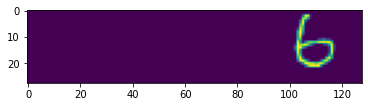

In [ ]:
f = make_sample(imgs_test, nums_test, shifts_test)

In [ ]:
model.predict(f)

[array([[1.1417558e-03, 6.2185514e-04, 7.7758357e-04, 2.4984947e-03,
         4.1617994e-04, 1.7226218e-03, 9.9244457e-01, 4.8429869e-05,
         2.9443039e-04, 3.4070377e-05]], dtype=float32),
 array([[94.21387]], dtype=float32)]

In [ ]:
model1.predict(f)

[array([[1.1417558e-03, 6.2185514e-04, 7.7758357e-04, 2.4984947e-03,
         4.1617994e-04, 1.7226218e-03, 9.9244457e-01, 4.8429869e-05,
         2.9443039e-04, 3.4070377e-05]], dtype=float32),
 array([[94.21387]], dtype=float32)]

In [53]:
zeros.astype('float32')

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23., 24., 25., 26.],
       [27., 28., 29., 30., 31., 32., 33., 34., 35.],
       [36., 37., 38., 39., 40., 41., 42., 43., 44.],
       [45., 46., 47., 48., 49., 50., 51., 52., 53.],
       [54., 55., 56., 57., 58., 59., 60., 61., 62.],
       [63., 64., 65., 66., 67., 68., 69., 70., 71.],
       [72., 73., 74., 75., 76., 77., 78., 79., 80.]], dtype=float32)